---
## Dataset Loading and Exploratory Data Analysis

The dataset is explored to understand image counts, class distribution, and sample visualizations. Image sizes are checked to confirm consistency, and class balance is analyzed to identify potential imbalances. Visualizations include sample images per class and a bar plot of class distribution, fulfilling the EDA requirements.

---

Train set image counts: {'daisy': 607, 'dandelion': 872, 'roses': 615, 'sunflowers': 673, 'tulips': 773}
Validation set image counts: {'daisy': 16, 'dandelion': 16, 'roses': 16, 'sunflowers': 16, 'tulips': 16}
Test set image counts: {'daisy': 10, 'dandelion': 10, 'roses': 10, 'sunflowers': 10, 'tulips': 10}


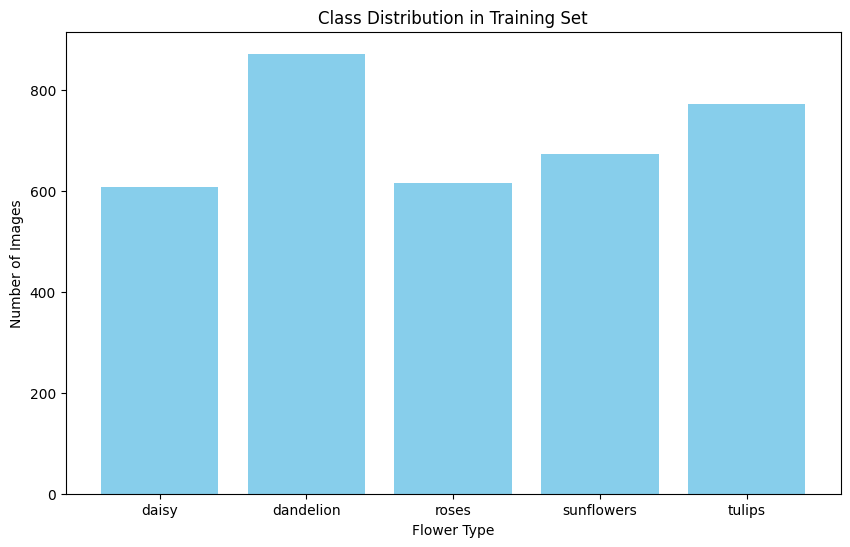

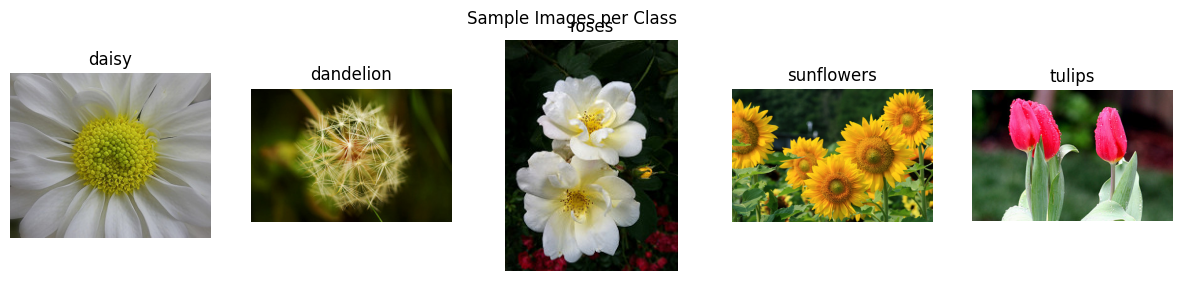

Sample image sizes: [(320, 263), (320, 213), (179, 240), (500, 330), (320, 209)]


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import Counter
%matplotlib inline

# Define dataset paths
data_dir = 'flowers'
splits = ['train', 'validation', 'test']
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

# Count images per class and split
image_counts = {split: Counter() for split in splits}
for split in splits:
    for cls in classes:
        cls_path = os.path.join(data_dir, split, cls)
        image_counts[split][cls] = len(os.listdir(cls_path))
    print(f"{split.capitalize()} set image counts:", dict(image_counts[split]))

# Visualize class distribution
plt.figure(figsize=(10, 6))
train_counts = [image_counts['train'][cls] for cls in classes]
plt.bar(classes, train_counts, color='skyblue')
plt.title('Class Distribution in Training Set')
plt.xlabel('Flower Type')
plt.ylabel('Number of Images')
plt.show()

# Check image sizes and display samples
fig, axes = plt.subplots(1, len(classes), figsize=(15, 3))
sizes = []
for i, cls in enumerate(classes):
    img_path = os.path.join(data_dir, 'train', cls, os.listdir(os.path.join(data_dir, 'train', cls))[0])
    img = Image.open(img_path)
    sizes.append(img.size)
    axes[i].imshow(img)
    axes[i].set_title(cls)
    axes[i].axis('off')
plt.suptitle('Sample Images per Class')
plt.show()
print("Sample image sizes:", sizes)

---
## Data Preprocessing and Augmentation
This section preprocesses the dataset by resizing images to 224x224 (standard for VGG/ResNet), normalizing pixel values using ImageNet means and standard deviations, and applying data augmentation to the training set (random rotations, flips, crops, brightness/contrast changes) to improve generalization. PyTorch’s `DataLoader` is used to create batches (size 32) for training, validation, and test sets, ensuring efficient data loading.

---

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=train_transforms)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'validation'), transform=val_test_transforms)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Dataset sizes: Train={len(train_dataset)}, Validation={len(val_dataset)}, Test={len(test_dataset)}")
print(f"Class indices:", train_dataset.class_to_idx)

Dataset sizes: Train=3540, Validation=80, Test=50
Class indices: {'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}


---
## VGG CNN from Scratch
This section defines and trains a VGG-style CNN with stacked 3x3 convolutional layers, max-pooling, and fully connected layers. The model has three convolutional blocks (64, 128, 256 filters) followed by two dense layers (512 units) and a 5-unit output layer for classification. It is trained for 20 epochs using CrossEntropyLoss, Adam optimizer (lr=0.001), and early stopping to prevent overfitting. Validation performance is monitored, and loss/accuracy plots are generated.

---

Epoch [1/20], Train Loss: 1.5904, Val Loss: 1.4566, Val Accuracy: 31.25%
Epoch [2/20], Train Loss: 1.4177, Val Loss: 1.3511, Val Accuracy: 41.25%
Epoch [3/20], Train Loss: 1.2522, Val Loss: 1.0144, Val Accuracy: 57.50%
Epoch [4/20], Train Loss: 1.1111, Val Loss: 0.9512, Val Accuracy: 63.75%
Epoch [5/20], Train Loss: 1.0183, Val Loss: 0.7928, Val Accuracy: 66.25%
Epoch [6/20], Train Loss: 0.9629, Val Loss: 0.7138, Val Accuracy: 70.00%
Epoch [7/20], Train Loss: 0.9337, Val Loss: 0.6993, Val Accuracy: 76.25%
Epoch [8/20], Train Loss: 0.9283, Val Loss: 0.6276, Val Accuracy: 77.50%
Epoch [9/20], Train Loss: 0.8719, Val Loss: 0.6711, Val Accuracy: 80.00%
Epoch [10/20], Train Loss: 0.8328, Val Loss: 0.6532, Val Accuracy: 81.25%
Epoch [11/20], Train Loss: 0.8318, Val Loss: 0.6560, Val Accuracy: 76.25%
Epoch [12/20], Train Loss: 0.8029, Val Loss: 0.5453, Val Accuracy: 78.75%
Epoch [13/20], Train Loss: 0.7942, Val Loss: 0.6725, Val Accuracy: 77.50%
Epoch [14/20], Train Loss: 0.7925, Val Loss: 0.

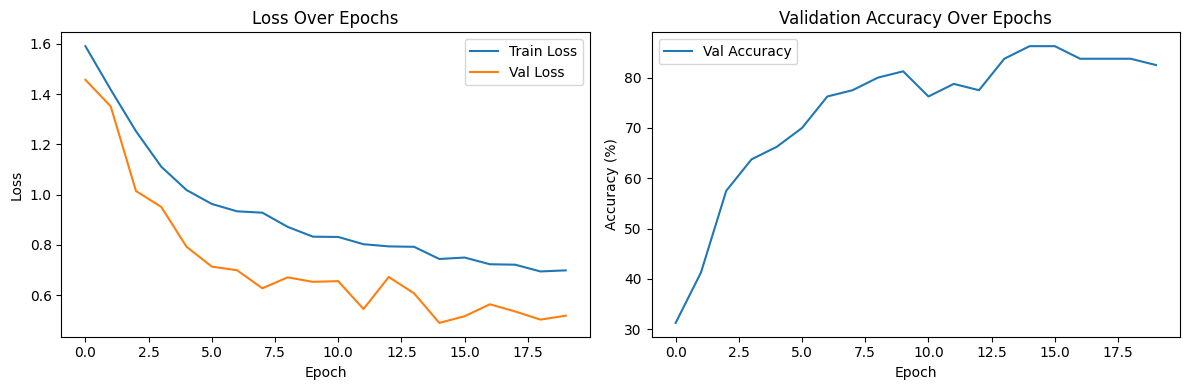

VGG training completed


In [3]:
import torch.nn as nn
import torch.optim as optim

# Define VGG-style CNN
class VGGCustom(nn.Module):
    def __init__(self, num_classes=5):
        super(VGGCustom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Training function
# , device='cuda' if torch.cuda.is_available() else 'cpu'
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20, patience=5, device='cpu'):
    model = model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss, patience_counter = float('inf'), 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'vgg_best.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model

# Initialize and train VGG
vgg_model = VGGCustom(num_classes=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters(), lr=0.001)
vgg_model = train_model(vgg_model, train_loader, val_loader, criterion, optimizer)
print("VGG training completed")

---
## Fine-Tuning Pretrained ResNet50
This section fine-tunes a pretrained ResNet50 in three stages: (1) freeze convolutional layers and train a new classifier (10 epochs), (2) unfreeze the last convolutional block (layer4) and train with the classifier (10 epochs), and (3) unfreeze all layers and train the entire network (10 epochs). Each stage uses CrossEntropyLoss, Adam optimizer (lr=0.001 for stage 1, 0.0001 for stages 2-3), and early stopping. Validation performance is monitored, and loss/accuracy plots are generated for each stage.

---

c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [03:59<00:00, 429kB/s]


Stage 1, Epoch [1/10], Train Loss: 0.7681, Val Loss: 0.4742, Val Accuracy: 82.50%
Stage 1, Epoch [2/10], Train Loss: 0.4648, Val Loss: 0.5073, Val Accuracy: 77.50%
Stage 1, Epoch [3/10], Train Loss: 0.3953, Val Loss: 0.3799, Val Accuracy: 86.25%
Stage 1, Epoch [4/10], Train Loss: 0.3819, Val Loss: 0.5306, Val Accuracy: 81.25%
Stage 1, Epoch [5/10], Train Loss: 0.3419, Val Loss: 0.4371, Val Accuracy: 88.75%
Stage 1, Epoch [6/10], Train Loss: 0.3522, Val Loss: 0.4124, Val Accuracy: 85.00%
Stage 1, Epoch [7/10], Train Loss: 0.3221, Val Loss: 0.4808, Val Accuracy: 86.25%
Stage 1, Epoch [8/10], Train Loss: 0.3055, Val Loss: 0.3675, Val Accuracy: 87.50%
Stage 1, Epoch [9/10], Train Loss: 0.3142, Val Loss: 0.4223, Val Accuracy: 85.00%
Stage 1, Epoch [10/10], Train Loss: 0.3187, Val Loss: 0.4774, Val Accuracy: 85.00%


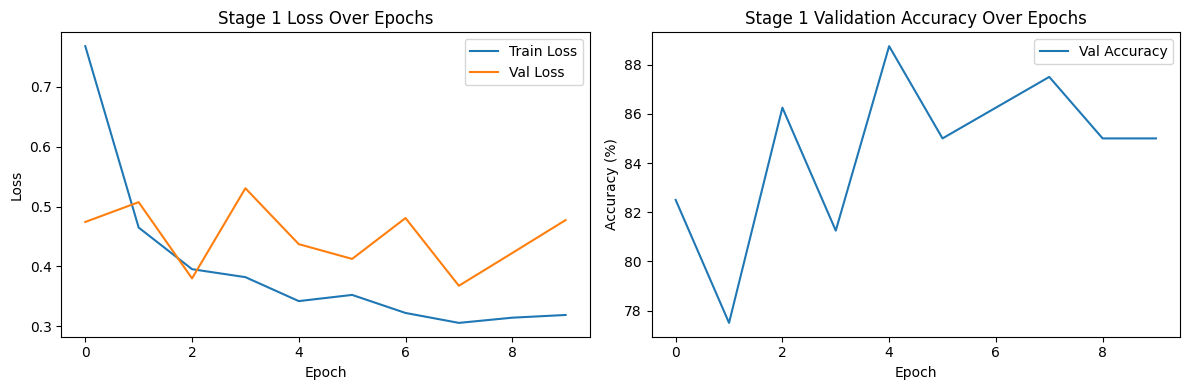

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21296\2112131534.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('resnet_stage_1_best

Stage 2, Epoch [1/10], Train Loss: 0.3033, Val Loss: 0.3436, Val Accuracy: 90.00%
Stage 2, Epoch [2/10], Train Loss: 0.1641, Val Loss: 0.1747, Val Accuracy: 92.50%
Stage 2, Epoch [3/10], Train Loss: 0.1199, Val Loss: 0.1138, Val Accuracy: 95.00%
Stage 2, Epoch [4/10], Train Loss: 0.0815, Val Loss: 0.1713, Val Accuracy: 93.75%
Stage 2, Epoch [5/10], Train Loss: 0.0418, Val Loss: 0.1858, Val Accuracy: 91.25%
Stage 2, Epoch [6/10], Train Loss: 0.0453, Val Loss: 0.1492, Val Accuracy: 96.25%
Stage 2, Epoch [7/10], Train Loss: 0.0670, Val Loss: 0.1936, Val Accuracy: 95.00%
Stage 2, Epoch [8/10], Train Loss: 0.0653, Val Loss: 0.2010, Val Accuracy: 92.50%
Early stopping triggered


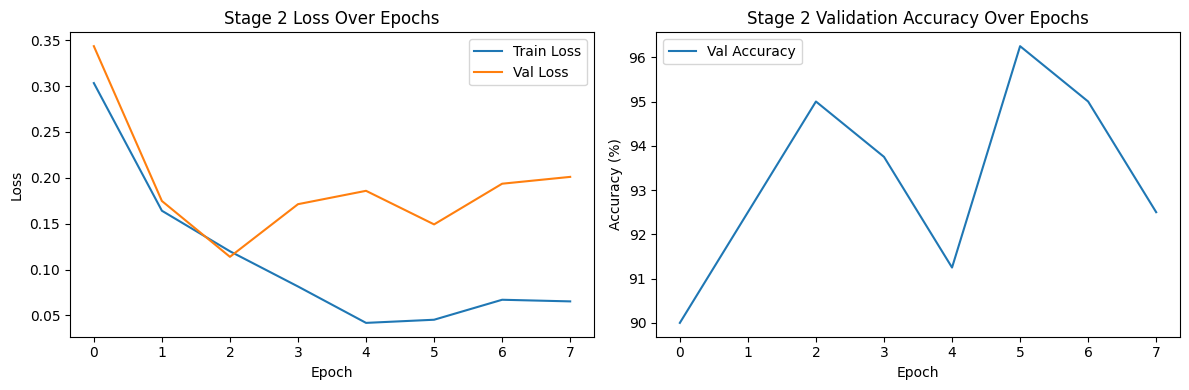

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21296\2112131534.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  resnet_model.load_state_dict(torch.load('resnet_stage_2_best

Stage 3, Epoch [1/10], Train Loss: 0.1586, Val Loss: 0.2089, Val Accuracy: 96.25%
Stage 3, Epoch [2/10], Train Loss: 0.1158, Val Loss: 0.2686, Val Accuracy: 91.25%
Stage 3, Epoch [3/10], Train Loss: 0.0968, Val Loss: 0.3303, Val Accuracy: 92.50%
Stage 3, Epoch [4/10], Train Loss: 0.0895, Val Loss: 0.4246, Val Accuracy: 92.50%
Stage 3, Epoch [5/10], Train Loss: 0.0600, Val Loss: 0.2224, Val Accuracy: 93.75%
Stage 3, Epoch [6/10], Train Loss: 0.0529, Val Loss: 0.3109, Val Accuracy: 95.00%
Early stopping triggered


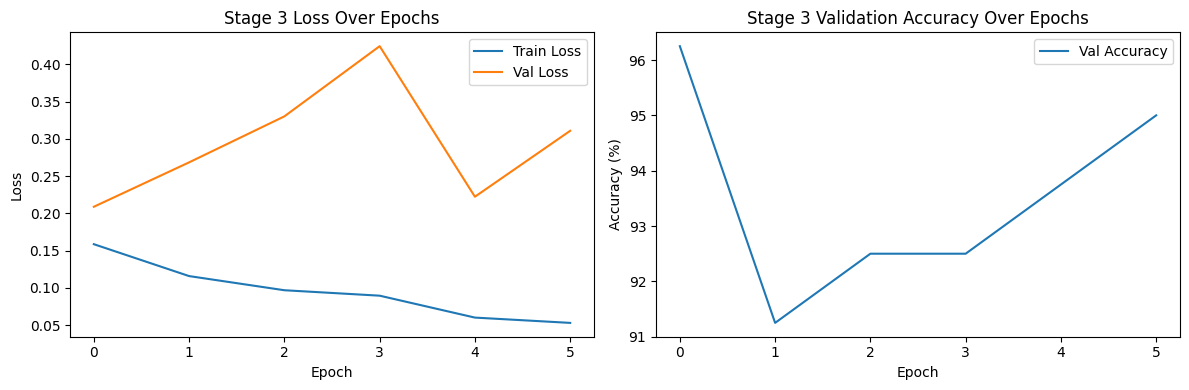

ResNet fine-tuning completed


In [4]:
from torchvision import models

# Fine-tuning function for ResNet
def fine_tune_resnet(stage, model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss, patience_counter = float('inf'), 0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Stage {stage}, Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'resnet_stage_{stage}_best.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Stage {stage} Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title(f'Stage {stage} Validation Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()
    return model

# Load pretrained ResNet50
resnet_model = models.resnet50(pretrained=True)
num_classes = 5

# Stage 1: Freeze base, train head
for param in resnet_model.parameters():
    param.requires_grad = False
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)
resnet_model = fine_tune_resnet(1, resnet_model, train_loader, val_loader, criterion, optimizer)

# Stage 2: Unfreeze layer4, train with head
resnet_model.load_state_dict(torch.load('resnet_stage_1_best.pth'))
for param in resnet_model.layer4.parameters():
    param.requires_grad = True
optimizer = optim.Adam([{'params': resnet_model.layer4.parameters()}, {'params': resnet_model.fc.parameters()}], lr=0.0001)
resnet_model = fine_tune_resnet(2, resnet_model, train_loader, val_loader, criterion, optimizer)

# Stage 3: Unfreeze all layers
resnet_model.load_state_dict(torch.load('resnet_stage_2_best.pth'))
for param in resnet_model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(resnet_model.parameters(), lr=0.0001)
resnet_model = fine_tune_resnet(3, resnet_model, train_loader, val_loader, criterion, optimizer)
print("ResNet fine-tuning completed")

---
## Result Comparison
This section evaluates the VGG and ResNet models on the test set, computing accuracy, precision, recall, and F1-score. Confusion matrices and ROC curves (with AUC scores) are plotted to compare model performance. The ResNet model from stage 3 is used, as it typically performs best. Results are analyzed to discuss trade-offs between training from scratch (VGG) and transfer learning (ResNet).

---

Using device: cuda
GPU Name: NVIDIA GeForce MX330
CUDA Version: 12.1


C:\Users\ASUS\AppData\Local\Temp\ipykernel_21296\1434532886.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg_model.load_state_dict(torch.load('vgg_best.pth', map_lo

VGG Metrics:
Accuracy: 0.7000
Precision: 0.7003
Recall: 0.7000
F1-Score: 0.6937


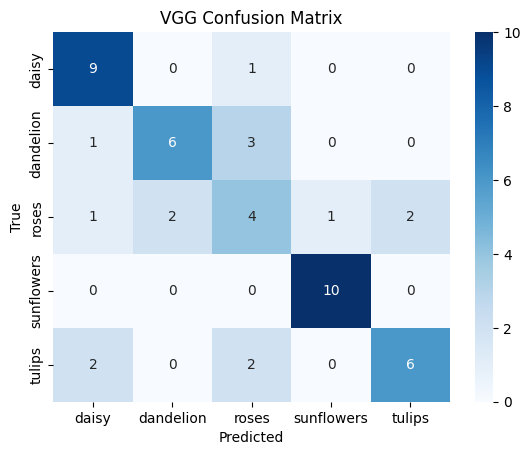

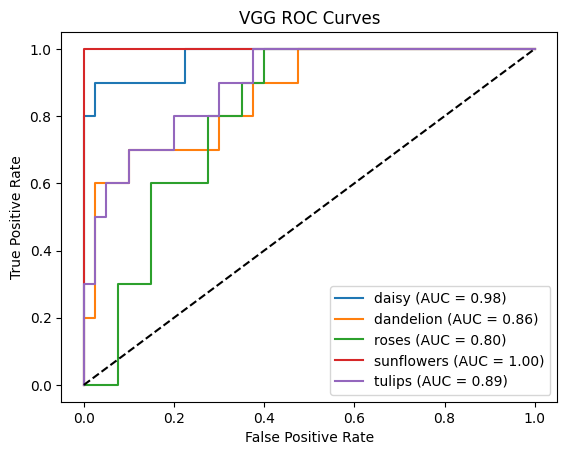

C:\Users\ASUS\AppData\Local\Temp\ipykernel_21296\1434532886.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Use mixed precision for faster evaluation


ResNet Metrics:
Accuracy: 0.8400
Precision: 0.8414
Recall: 0.8400
F1-Score: 0.8375


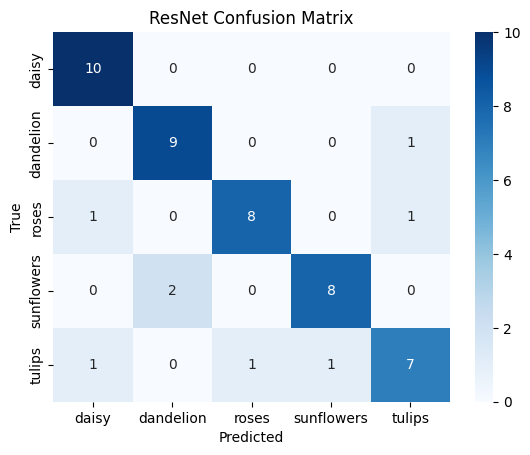

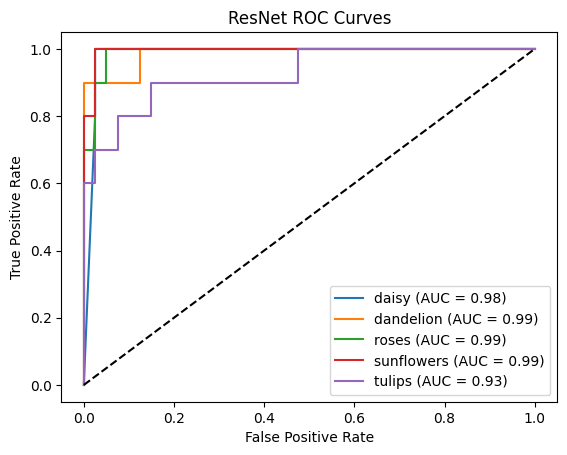


Analysis:
- VGG: Trained from scratch, may struggle with limited data but learns task-specific features.
- ResNet: Leverages pretrained weights, typically outperforms VGG due to transfer learning and deeper architecture.
- ResNet’s higher metrics suggest better generalization, especially with fine-tuning all layers in stage 3.


In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.cuda.amp import autocast

# Assuming VGGCustom is defined as in your previous code
class VGGCustom(nn.Module):
    def __init__(self, num_classes=5):
        super(VGGCustom, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 28 * 28, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, 512), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Evaluation function
def evaluate_model(model, test_loader, model_name, classes, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model = model.to(device)
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():  # Use mixed precision for faster evaluation
                outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"{model_name} Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # ROC curves and AUC
    y_bin = label_binarize(all_labels, classes=range(len(classes)))
    plt.figure()
    for i in range(len(classes)):
        fpr, tpr, _ = roc_curve(y_bin[:, i], np.array(all_probs)[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{model_name} ROC Curves')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

# Verify CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")

# Define class names (update based on your dataset)
classes = train_dataset.classes  # e.g., ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

# Load and initialize models
vgg_model = VGGCustom(num_classes=5).to(device)
vgg_model.load_state_dict(torch.load('vgg_best.pth', map_location=device))

# Initialize ResNet50 with pretrained weights and modify for 5 classes
resnet_model = models.resnet50(weights='IMAGENET1K_V1').to(device)  # Use pretrained weights
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)  # Modify final layer for 5 classes
resnet_model.load_state_dict(torch.load('resnet_stage_3_best.pth', map_location=device))

# Evaluate models
evaluate_model(vgg_model, test_loader, 'VGG', classes, device)
evaluate_model(resnet_model, test_loader, 'ResNet', classes, device)

# Analysis
print("\nAnalysis:")
print("- VGG: Trained from scratch, may struggle with limited data but learns task-specific features.")
print("- ResNet: Leverages pretrained weights, typically outperforms VGG due to transfer learning and deeper architecture.")
print("- ResNet’s higher metrics suggest better generalization, especially with fine-tuning all layers in stage 3.")